In [37]:
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
import networkx
from bokeh.models import (BoxSelectTool, Circle, EdgesAndLinkedNodes, HoverTool,
                          MultiLine, NodesAndLinkedEdges, Plot, Range1d, TapTool,)
from bokeh.palettes import Spectral4
import itertools
import copy
import networkx as nx
import matplotlib.pyplot as plt
import sys, getopt
import re
import random
import numpy as np

In [214]:
def random_color():
    color = list(np.random.uniform(range(1), size=3))
    return tuple(color)

def convert_colors(values):
    convert = []
    for value in values:
        indi = []
        #print(value)
        for a in value:
            indi.append((int)(a*255))
        convert.append(tuple(indi))
    return convert
def convert_color(values):
    convert = []
    for value in values:
        convert.append((int)(value*255))
    return tuple(convert)
def parseTxtFile(name, with_coloring):
    withWeight  = False
    sum=0
    g = nx.Graph()
    with open(name) as f:
        lines = f.readlines()
    color_brk = 0
    chr_dict = {}
    chr_color = {}
    node_color = {}
    if (with_coloring):
        for i in range(len(lines)):
            if (lines[i][0]=='%'):
                color_brk = int(i) + 1
                break
            v = re.split(" |\n",lines[i])
            chr_dict[v[0]] = v[1]
            
    # assign random colour to dictionary
    for key, value in chr_dict.items():
        if value in chr_color:
            node_color[key] = chr_color[value]
            continue 
        
        chr_color[value] = random_color()
        node_color[key] = chr_color[value]
    
    # edges
    for i in range(color_brk,len(lines)):
        if (lines[i][0]=='-'):
            brk = int(i)
            break
        wl = -1
        prev = False 
        v = re.split("--|\n|,",lines[i])
        if (len(v)==4):
            #if (v[2]>=50)
            g.add_edge(v[0],v[1], Color='red', weight=v[2])
        else:
            g.add_edge(v[0],v[1], Color='red')
        
    # nodes & position
    for i in range(brk+1,len(lines)):
        if (lines[i][0]=='^'):
            brk = i + 1
            break
        
        v = re.split("\n|[|]|[)]|[(]|,",lines[i])
        g.add_node(v[0],X=float(v[2]), Y=float(v[3]),Color = node_color[v[0]])
    
    #size
    for r in range(len(lines[brk])):
        if (lines[brk][r]==','):
            comma = r
        if (lines[brk][r]=='\n'):
            end = r
    lines[brk]
    return [g,[int(lines[brk][:comma]), int(lines[brk][comma+1:end])], withWeight]


def plot(g, coor, outFile, withWeight):
    #Establish which categories will appear when hovering over each node
    HOVER_TOOLTIPS = [("Contig", "@index")]

    #Create a plot — set dimensions, toolbar, and title
    plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title='Graph')

    # Define node positions data structure (dict) for plotting
    node_positions = {node[0]: (node[1]['X'], node[1]['Y']) for node in g.nodes(data=True)}
    # Define data structure (list) of edge colors for plotting
    edge_colors = [e[2]['Color'] for e in g.edges(data=True)]
    #node colors
    node_colors = [node[1]['Color'] for node in g.nodes(data=True)]
    cm = 1/2.54
    plt.figure(figsize=(coor[0]*cm, coor[1]*cm))
    nx.draw(g, pos=node_positions,node_color=node_colors, edge_color=edge_colors, node_size=50, with_labels = True, font_size=5)
    if (withWeight):
        labels = {e: g.edges[e]['weight'] for e in g.edges}
        nx.draw_networkx_edge_labels(g,pos=node_positions, edge_labels=labels, font_size=5)
    plt.savefig(outFile, dpi=1000)
    
    #node_colors_rgb = convert_color(node_colors)
    for node in g.nodes(data=True):
        node[1]['node_color'] = convert_color(node[1]['Color'])
    network_graph = from_networkx(g, node_positions, scale=10, center=(0, 0))
    
    
    node_hover_tool = HoverTool(renderers=[network_graph.node_renderer], 
                            tooltips=[("Contig", "@index")])
    edge_hover_tool = HoverTool(renderers=[network_graph.edge_renderer], 
                        tooltips=[("weight", "@weight")])
    plot.add_tools(edge_hover_tool, node_hover_tool)
    
    network_graph.node_renderer.glyph = Circle(size=15, fill_color="node_color")
    network_graph.node_renderer.selection_glyph = Circle(size=15, fill_color=Spectral4[2])
    network_graph.node_renderer.hover_glyph = Circle(size=15, fill_color=Spectral4[1])

    network_graph.edge_renderer.glyph = MultiLine(line_color="#CCCCCC", line_alpha=0.8, line_width=5)
    network_graph.edge_renderer.selection_glyph = MultiLine(line_color=Spectral4[2], line_width=5)
    network_graph.edge_renderer.hover_glyph = MultiLine(line_color=Spectral4[1], line_width=5)
    
    network_graph.selection_policy = NodesAndLinkedEdges()
    network_graph.inspection_policy = EdgesAndLinkedNodes()
    #Add network graph to the plot
    plot.renderers.append(network_graph)


    show(plot)
    save(plot, filename=outFile+".html")

## Input file

/home/cecilia/miniconda3/envs/env/lib/python3.7/site-packages/bokeh/io/saving.py:126: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/home/cecilia/miniconda3/envs/env/lib/python3.7/site-packages/bokeh/io/saving.py:139: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


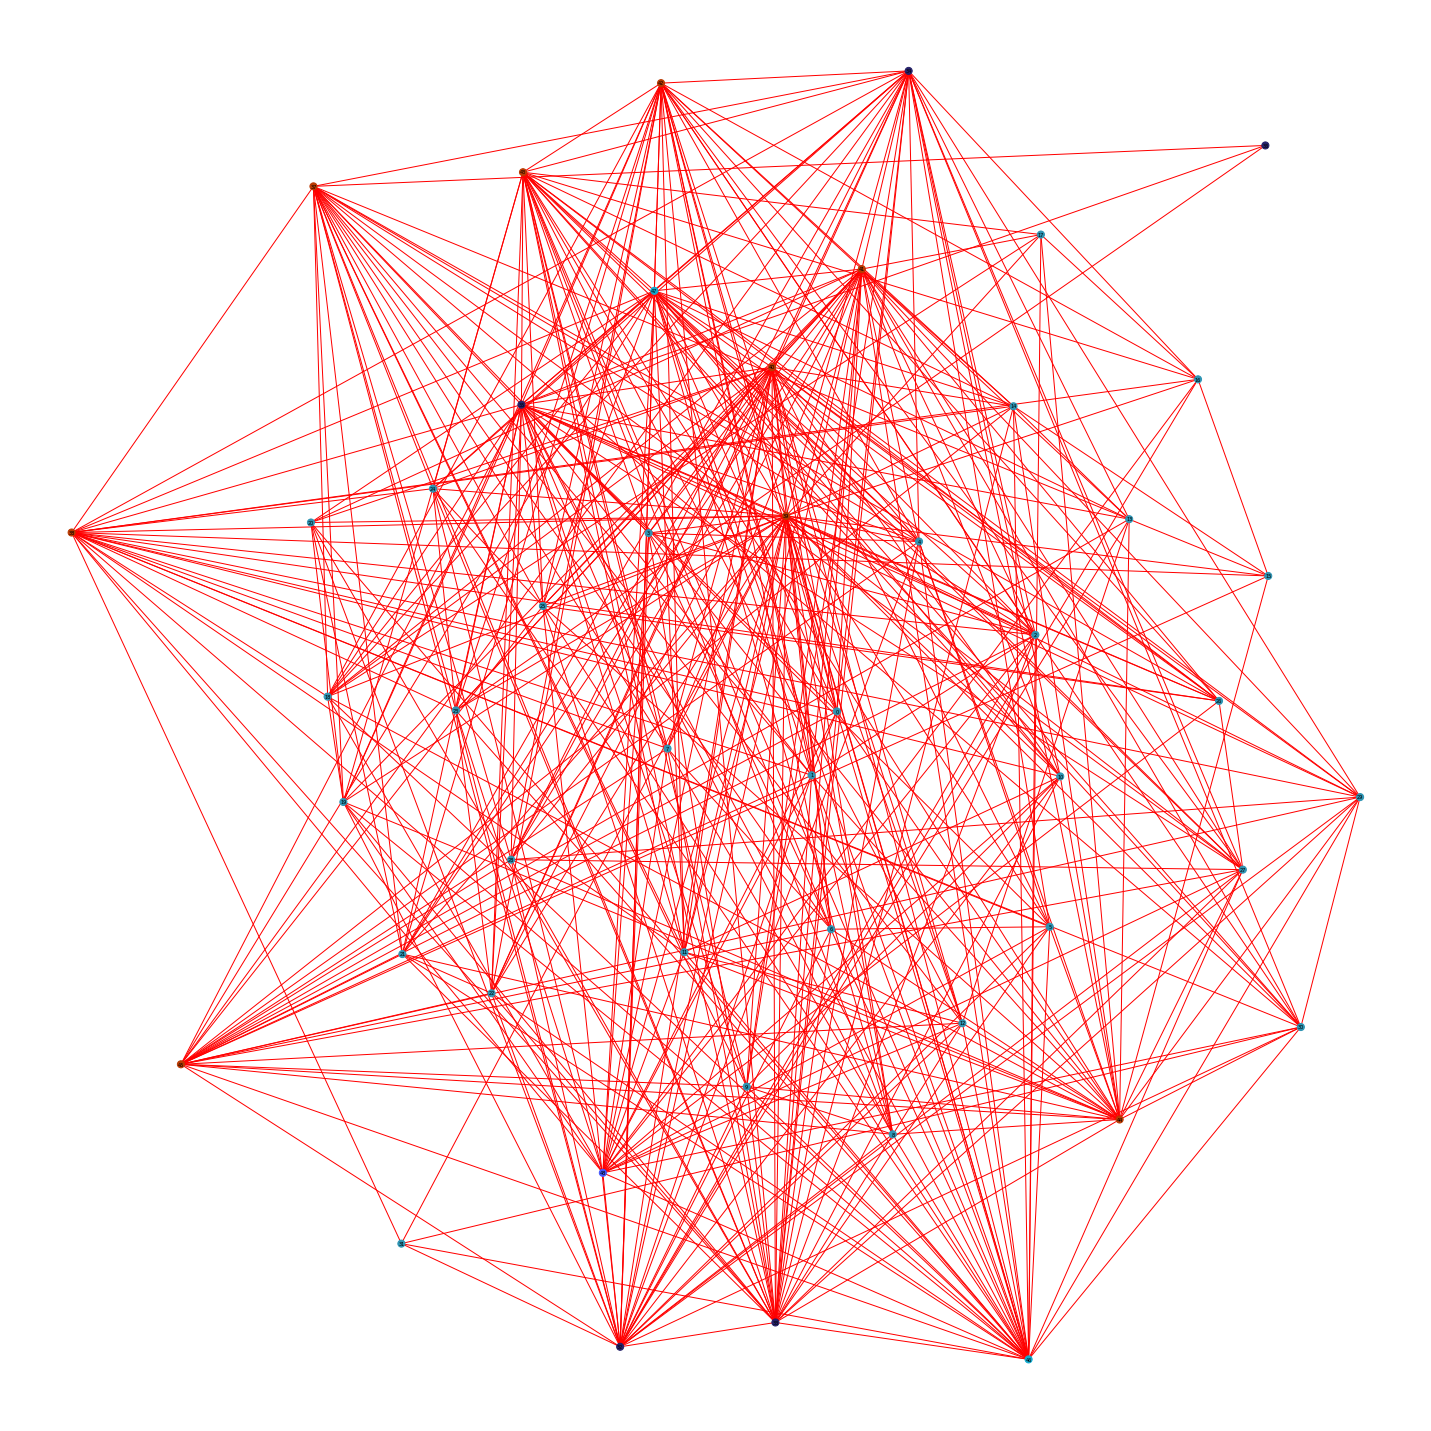

In [215]:
results = parseTxtFile('../../tarantula/build/window_graph_output.txt',True)
plot(results[0], results[1], '../../tarantula/build/window_graph_output', results[2])

In [216]:
results = parseTxtFile('../../../hifiasm_wg/output.txt',True)

## Output file

/home/cecilia/miniconda3/envs/env/lib/python3.7/site-packages/bokeh/io/saving.py:126: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/home/cecilia/miniconda3/envs/env/lib/python3.7/site-packages/bokeh/io/saving.py:139: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


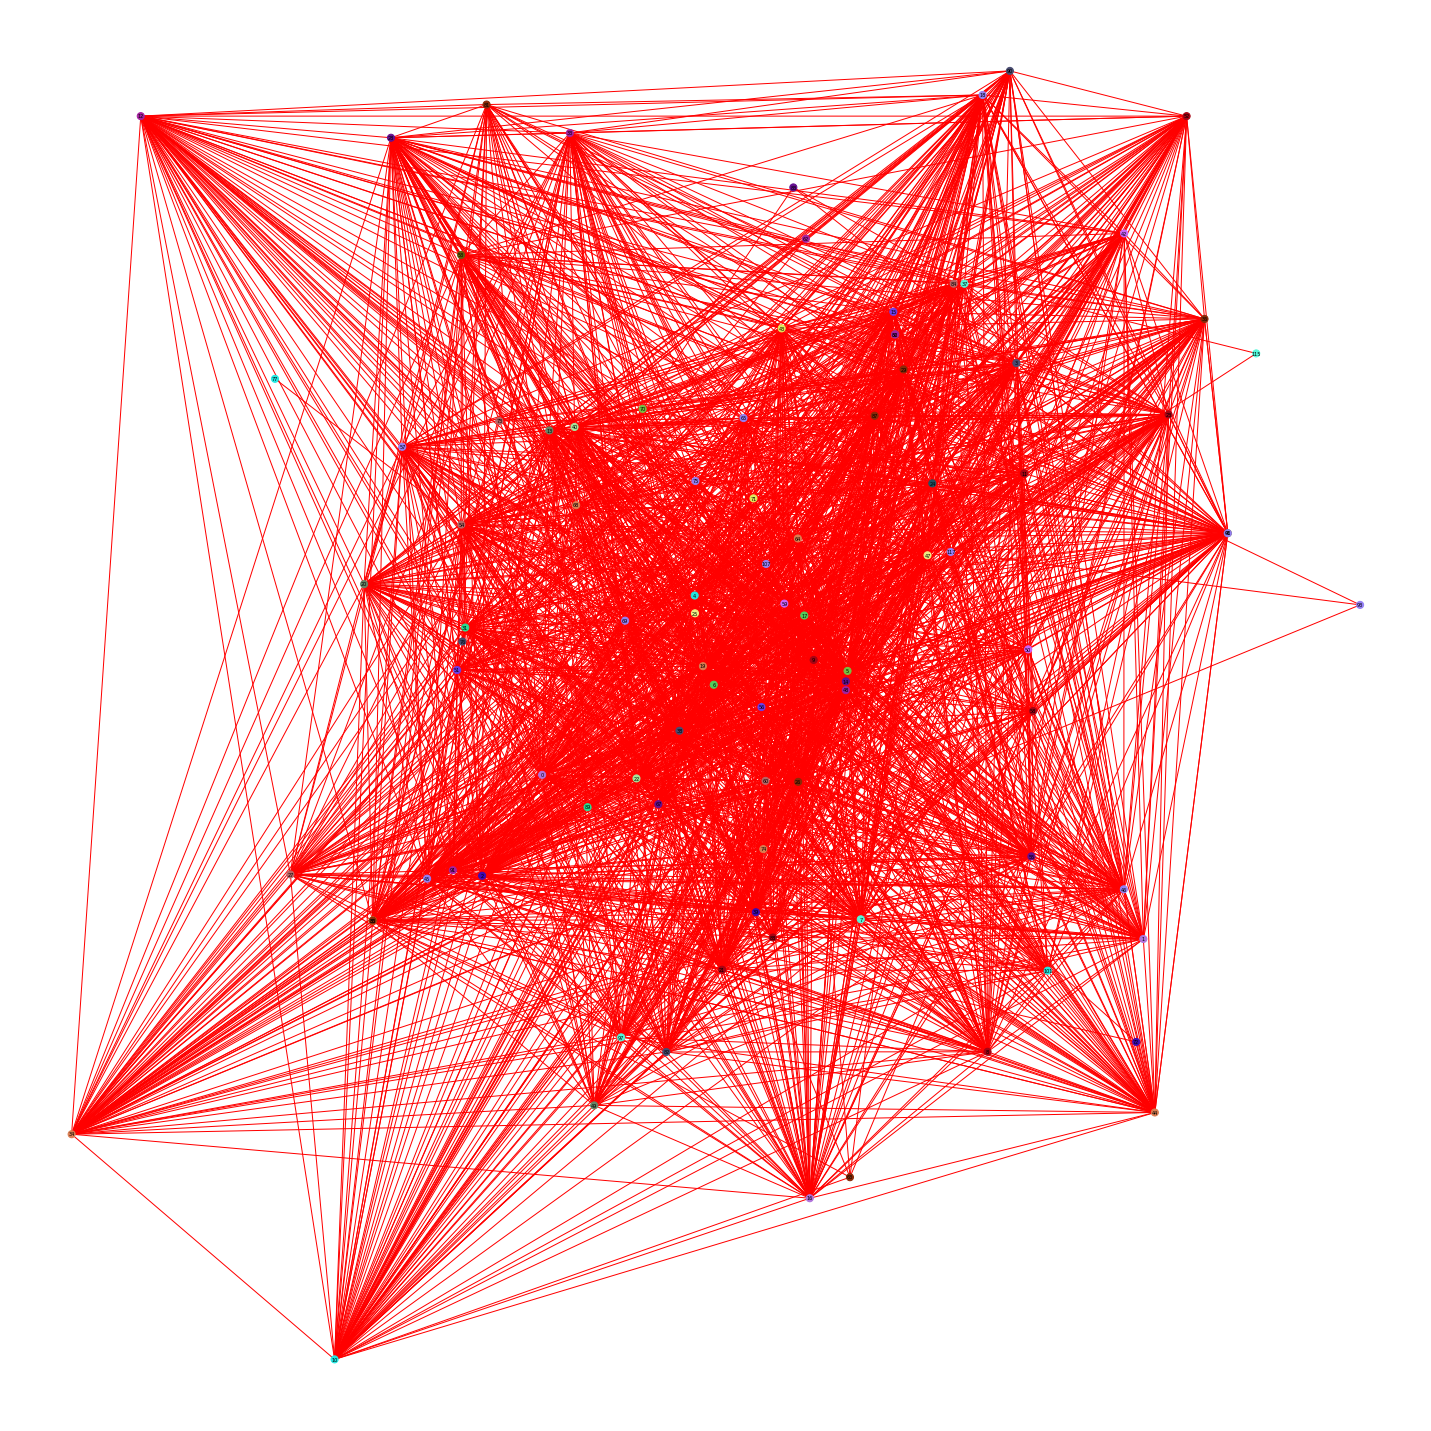

In [217]:
plot(results[0], results[1], '../../../hifiasm_wg/graph_output_coloured', results[2])

In [220]:
def plotFR(g, coor, outFile, withWeight, iterations):
    #Establish which categories will appear when hovering over each node
    HOVER_TOOLTIPS = [("Contig", "@index")]

    #Create a plot — set dimensions, toolbar, and title
    plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title='Graph')

    # Define node positions data structure (dict) for plotting
    node_positions = {node[0]: (node[1]['X'], node[1]['Y']) for node in g.nodes(data=True)}
    # Define data structure (list) of edge colors for plotting
    edge_colors = [e[2]['Color'] for e in g.edges(data=True)]
    #node colors
    node_colors = [node[1]['Color'] for node in g.nodes(data=True)]
    cm = 1/2.54
    plt.figure(figsize=(coor[0]*cm, coor[1]*cm))
    nx.draw(g, pos=node_positions,node_color=node_colors, edge_color=edge_colors, node_size=50, with_labels = True, font_size=5)
    if (withWeight):
        labels = {e: g.edges[e]['weight'] for e in g.edges}
        new_pos = nx.spring_layout(g,weight='weight', pos = node_positions, iterations=iterations)
        nx.draw_networkx_edge_labels(g,pos= new_pos, edge_labels=labels, font_size=5)
    plt.savefig(outFile, dpi=1000)
    
    #node_colors_rgb = convert_color(node_colors)
    for node in g.nodes(data=True):
        node[1]['node_color'] = convert_color(node[1]['Color'])
    network_graph = from_networkx(g, node_positions, scale=10, center=(0, 0))
    
    
    node_hover_tool = HoverTool(renderers=[network_graph.node_renderer], 
                            tooltips=[("Contig", "@index")])
    edge_hover_tool = HoverTool(renderers=[network_graph.edge_renderer], 
                        tooltips=[("weight", "@weight")])
    plot.add_tools(edge_hover_tool, node_hover_tool)
    
    network_graph.node_renderer.glyph = Circle(size=15, fill_color="node_color")
    network_graph.node_renderer.selection_glyph = Circle(size=15, fill_color=Spectral4[2])
    network_graph.node_renderer.hover_glyph = Circle(size=15, fill_color=Spectral4[1])

    network_graph.edge_renderer.glyph = MultiLine(line_color="#CCCCCC", line_alpha=0.8, line_width=5)
    network_graph.edge_renderer.selection_glyph = MultiLine(line_color=Spectral4[2], line_width=5)
    network_graph.edge_renderer.hover_glyph = MultiLine(line_color=Spectral4[1], line_width=5)
    
    network_graph.selection_policy = NodesAndLinkedEdges()
    network_graph.inspection_policy = EdgesAndLinkedNodes()
    #Add network graph to the plot
    plot.renderers.append(network_graph)


    show(plot)
    save(plot, filename=outFile+".html")

/home/cecilia/miniconda3/envs/env/lib/python3.7/site-packages/bokeh/io/saving.py:126: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/home/cecilia/miniconda3/envs/env/lib/python3.7/site-packages/bokeh/io/saving.py:139: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


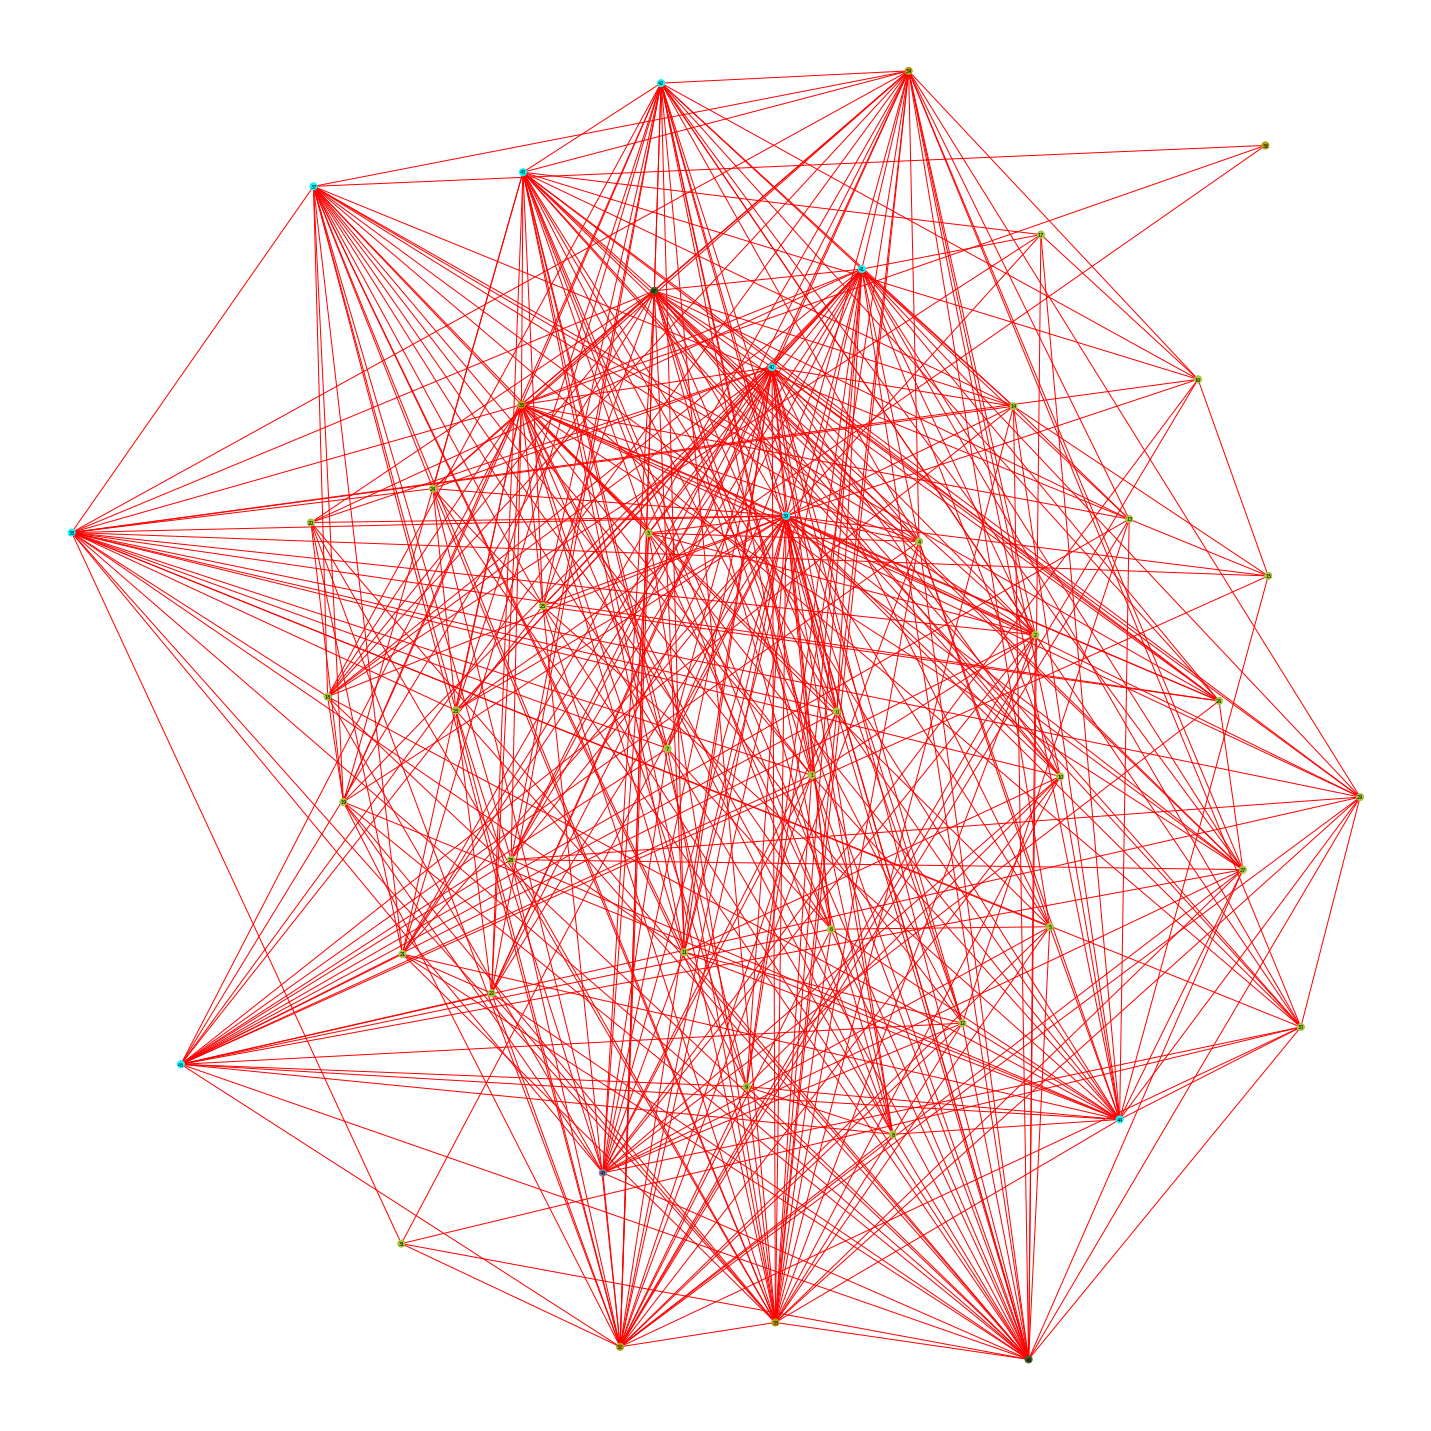

In [221]:
results = parseTxtFile('../../tarantula/build/window_graph_output.txt',True)
plotFR(results[0], results[1], '../../tarantula/build/window_graph_output', results[2],100000)

/home/cecilia/miniconda3/envs/env/lib/python3.7/site-packages/bokeh/io/saving.py:126: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/home/cecilia/miniconda3/envs/env/lib/python3.7/site-packages/bokeh/io/saving.py:139: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


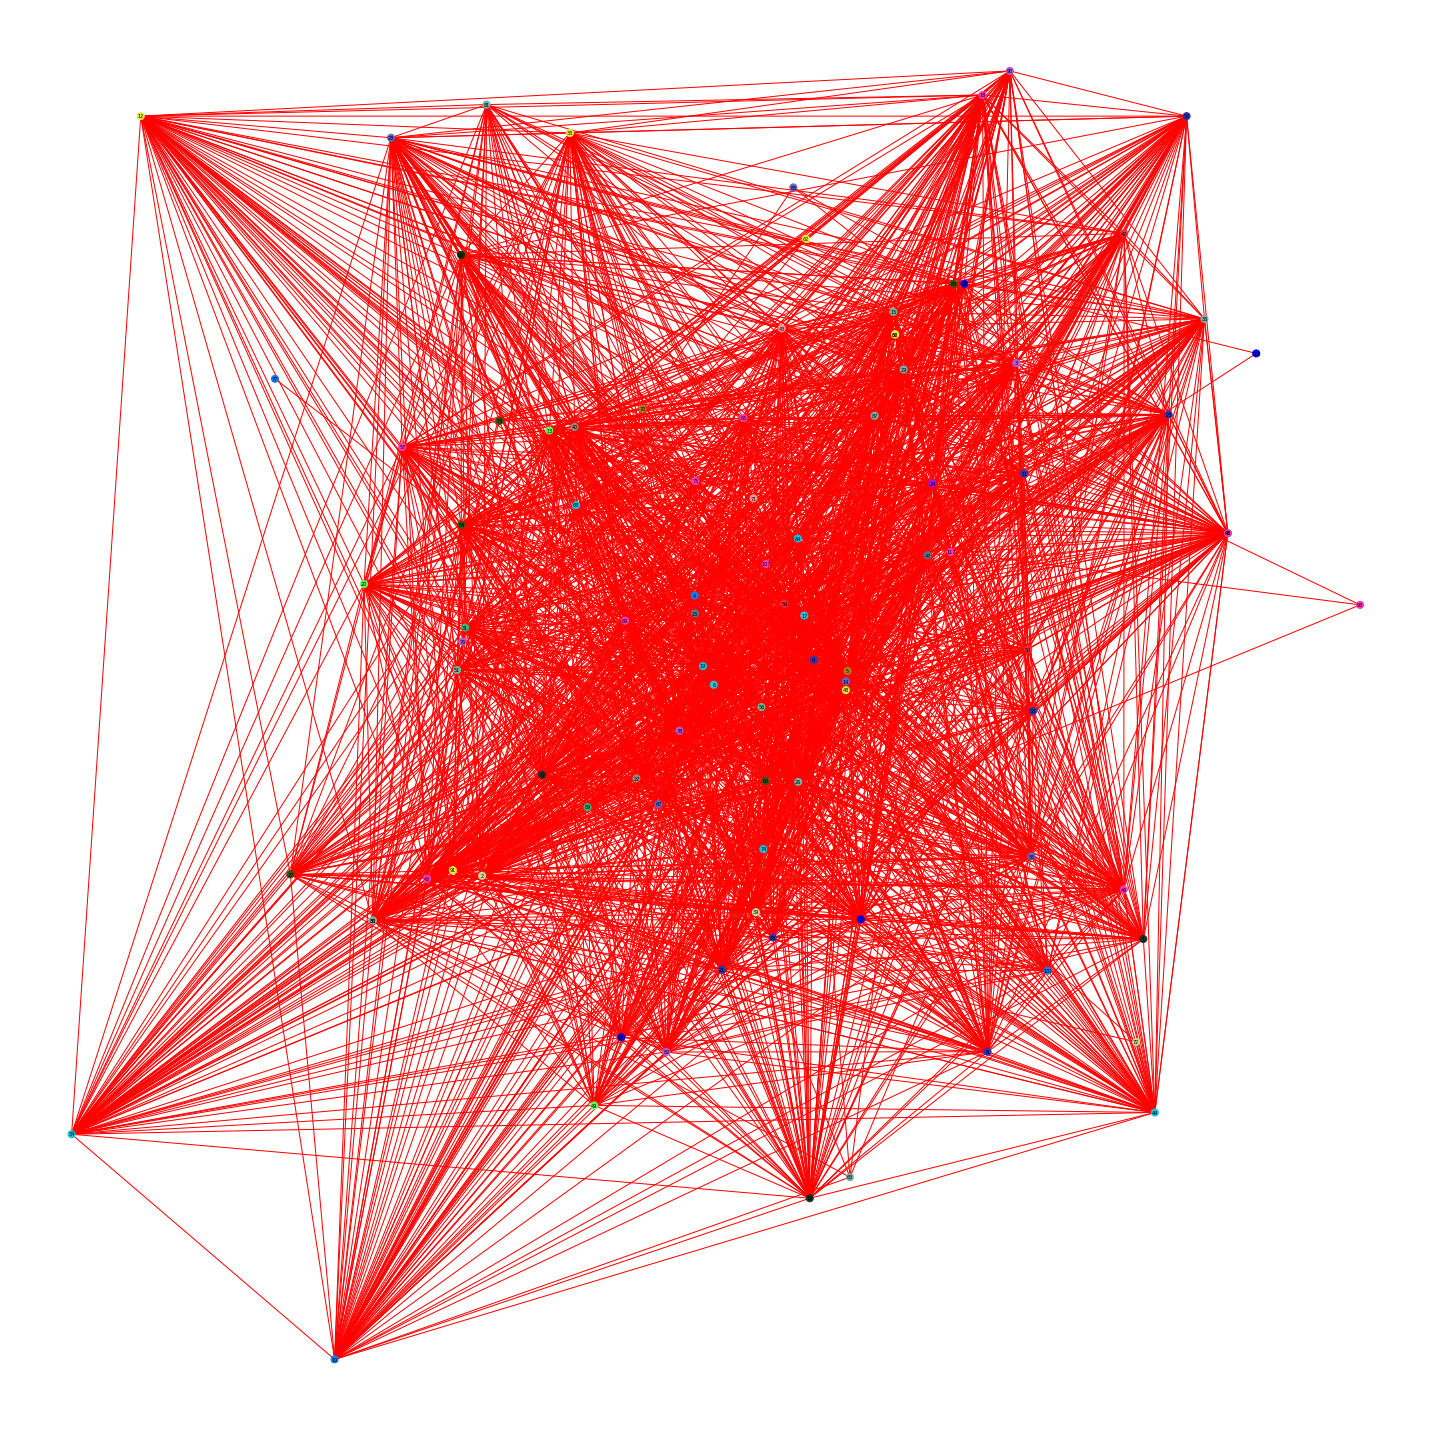

In [222]:
results = parseTxtFile('../../../hifiasm_wg/output.txt',True)
plotFR(results[0], results[1], '../../../hifiasm_wg/graph_output_coloured', results[2],100000)

In [ ]:
results = parseTxtFile('../../../dmel_good/run8/graph_output.txt',True)
plot(results[0], results[1], '../../../dmel_good/run8/graph_output', results[2])